In [ ]:
# install DeepXDE

%pip install deepxde

# import packages

import deepxde as dde
import numpy as np

from deepxde.backend import tf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.6 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



**Fitting Exponential Functions**

In [49]:
# fit an exponential function to the l2 errors in extrapolation

import scipy
from scipy.optimize import curve_fit

def exp_fit(y: list) -> tuple:
    """
    Fit an exponential curve to the data (x, y).

    Parameters
    ----------
    y : the y values of the data

    Returns
    -------
    popt : optimal values for the parameters so that the sum of the squared
              residuals of f(xdata, *popt) - ydata is minimized

    pcov : the estimated covariance of popt
    """
    x = np.arange(0, len(y))
    popt, pcov = curve_fit(lambda t,a,b,c: a*np.exp(b*t)+c, x, y, p0=(1, 1e-6, -1))
    return popt, pcov


# plot the data and the exponential curve

import matplotlib.pyplot as plt

def plot_exp_fit(y: list, popt: tuple) -> None:
    """
    Plot the data and the exponential curve.

    Parameters
    ----------
    y : the y values of the data

    popt : optimal values for the parameters so that the sum of the squared
              residuals of f(xdata, *popt) - ydata is minimized

    Returns
    -------
    None
    """
    x = np.arange(0, len(y))
    plt.plot(x, y, 'ko', label="Original Data")
    plt.plot(x, popt[0]*np.exp(popt[1]*x) + popt[2], 'r-', label="Fitted Curve")
    plt.legend()
    plt.show()

**Fourier Analysis**

In [ ]:
def get_fft(y, sampling_rate):
  # Calculate the Fourier transform of f(x)
  fourier = np.fft.fft(y.squeeze())

  length = len(y)

  # Calculate the corresponding frequencies
  freq = np.fft.fftfreq(length, 1/sampling_rate)

  results = list(zip(freq, np.abs(fourier)))
  filtered = [(x, y) for (x, y) in results if x > 0]
  results = list(zip(*filtered))

  return results

**Diffusion-Reaction Equation**

In [ ]:
M = 1
K = 10

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    d = 1

    residual = 3 * tf.sin(2 * x[:, 0:1]) / 2

    for l in range(3, K + 1):
        residual += (l ** 2 - 1) * tf.sin(l * x[:, 0:1]) / l

    return (dy_t - d * dy_xx - tf.exp(-M * x[:, 1:]) * residual)


def func(x):
    residual = np.sin(x[:, 0:1]) + np.sin(2 * x[:, 0:1]) / 2

    for l in range(3, K + 1):
        residual += np.sin(l * x[:, 0:1]) / l

    return (np.exp(-M * x[:, 1:]) * residual)

In [ ]:
geom = dde.geometry.Interval(-np.pi, np.pi)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain= int(K * 320),
    num_boundary= int(K * 20),
    num_initial= int(K * 10),
    solution=func,
    num_test=10000,
)

# set up the model
layer_size = [2] + [100] * 5 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# net = dde.nn.MsFFN(layer_size, activation, initializer, sigmas=[1, 10])

model = dde.Model(data, net)

model.compile("adam", lr=1e-4, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.109171 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.313928 s



In [ ]:
model.train(iterations=80000)

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.12e+02, 2.31e-01, 1.17e+00]    [1.14e+02, 2.31e-01, 1.17e+00]    [1.30e+00]    
1000      [7.11e+00, 6.49e-02, 1.52e-01]    [7.27e+00, 6.49e-02, 1.52e-01]    [4.29e-01]    
2000      [2.27e+00, 2.59e-04, 6.70e-03]    [2.32e+00, 2.59e-04, 6.70e-03]    [1.01e-01]    
3000      [6.94e-01, 1.52e-02, 2.94e-03]    [6.28e-01, 1.52e-02, 2.94e-03]    [7.24e-02]    
4000      [8.83e-02, 2.23e-03, 3.59e-03]    [4.69e-02, 2.23e-03, 3.59e-03]    [6.71e-02]    
5000      [5.82e-03, 1.90e-04, 2.03e-04]    [4.99e-03, 1.90e-04, 2.03e-04]    [9.88e-03]    
6000      [2.23e-03, 9.00e-05, 8.54e-05]    [2.04e-03, 9.00e-05, 8.54e-05]    [6.22e-03]    
7000      [1.37e-03, 2.67e-05, 3.93e-05]    [1.24e-03, 2.67e-05, 3.93e-05]    [4.07e-03]    
8000      [9.43e-04, 7.02e-06, 1.99e-05]    [8.47e-04, 7.02e-06, 1.99e-05]    [2.74e-03]    
9000      [6.94e-04, 2.92e-06, 1.26e-05]    [6.22e-

(<deepxde.model.LossHistory at 0x7f49a12f5180>,
 <deepxde.model.TrainState at 0x7f49a12f6f20>)

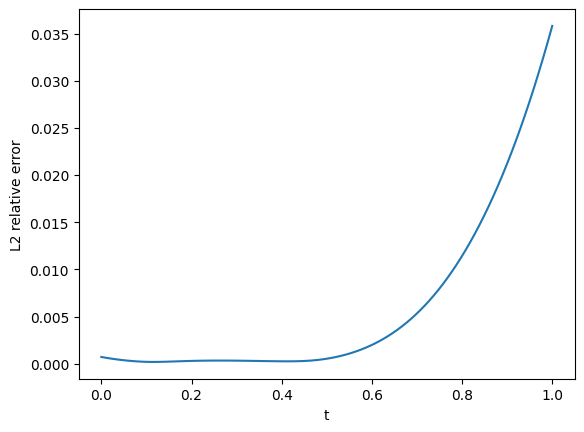

In [45]:
# compute the L2 relative error between the true solution and the predicted solution

rel_l2_errors = []

for t in range(100):
    x = geom.uniform_points(256, True)
    t = np.full(256, t/100)
    x = np.hstack((x, t.reshape(-1, 1)))
    y_pred = model.predict(x)

    y_true = func(x)

    # collect the relative L2 errors in a list
    rel_l2_errors.append(dde.metrics.l2_relative_error(y_true, y_pred))


# plot the relative L2 errors

m = np.linspace(0, 1, 100)
plt.plot(m, rel_l2_errors)
plt.xlabel("t")
plt.ylabel("L2 relative error")
plt.show()

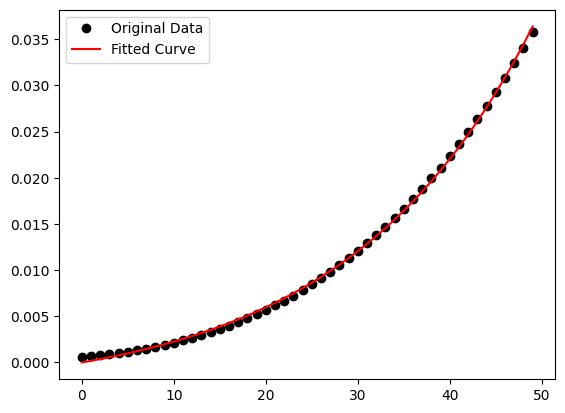

(array([ 0.00353448,  0.04946832, -0.00353636]), array([[ 1.42157041e-08, -7.59246809e-08, -2.19473183e-08],
       [-7.59246809e-08,  4.10221740e-07,  1.14799097e-07],
       [-2.19473183e-08,  1.14799097e-07,  3.65172462e-08]]))


In [50]:
plot_exp_fit(rel_l2_errors[50:], exp_fit(rel_l2_errors[50:])[0])

print(exp_fit(rel_l2_errors[50:]))

In [ ]:
def gen_testdata():
  full_domain = np.zeros(shape=(25600, 2))
  true_sol = np.zeros(shape=(25600,))
  for time_step in range(100):
      time = time_step * .01
      x = geom.uniform_points(256, True)
      t = np.full(256, time)
      x = np.hstack((x, t.reshape(-1, 1)))

      start = int(256 * time * 100)
      end = start + 256
      full_domain[start:end] = x

      ground_truth = func(x)
      # print(len(func(x)))
      true_sol[start:end] = ground_truth[0]
  
  return full_domain, true_sol

In [ ]:
X, y_true = gen_testdata()

t = 0.99

start = round(256 * t * 100)
end = start + 256

true_freq, true_fourier = get_fft(y_true[start:end], 256/2)

In [ ]:
true_fourier

(0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

**Burger's Equation**

**Allen-Cahn Equation**